In [1]:
import re
import time

import pandas as pd
import numpy as np
import pylab as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing

# Step 1: Read CSV and data cleaning

To save typos in the future, we first convert a string that is camelcase into snake_case. Use underscores to avoid spaces in between of compound words.

In [2]:
def camel_to_snake(column_name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', column_name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

def read(file_name):
    if not os.path.isfile(file_name):
        raise ValueError('File Not Found')
        
    ext = file_name.split('.')[-1].lower()
    if 'csv' == ext:
        df = pd.read_csv(file_name)
    elif 'xls' in ext:
        df = pd.read_excel(file_name)
    elif 'json' == ext:
        df = pd.read_json(file_name)
    else:
        raise ValueError('Only support csv, xls and json')

    return df

## Data cleaning and create dummy variables

### Basic description: 
Projects data lists the demographics data of school profiles and associated socio-economic factors, and the project applications data. Outcomes data lists the outcomes(whether it is exciting or not) for each project. To be exciting, a project must meet all of the top five criteria,and meet at least one extra criteria. Donations data comprises donors information and donation details associated with each individual project. Essays data conclude all essay questions funding application materials. Resources data specifies those who requested resources. 

Data choosing criteria: Since the natural language processing is beyond the scope of the project, we will rule 'Essays' dataset out of our analysis.  

### Why we clean our data?

There are many duplicates in donation data as there are many entries for different donors. In short, we clean out the duplicate records via multiple functions, including create dummy variables, count the number of true and false values and produce new variables and sum all the columns up for one single projectid. 

### How do we clean the data and create dummy variables for categorical data?

##### General Principles: 
1. For those categorical data, we create dummy variables for them.
2. Remove essay questions.
3. Keep one row in the donation dataset and resource dataset.

##### Guidebook:
Here are the principles to eliminate duplicate records of donation entries for one project. There are multiple donor records for one project id. In order to remove irrelevant rows, we create dummy variables, or sum up the record entries or count the times for each category for categorical data. In addition, we leave the donation_timestamp which has the latest timestamp in the data.

At the end, we only leave one row of donation record in the donations dataset. The same as resources dataset, where the 'total' are the sums of item price multiply by item_quantity for all donations.


### How do we merge the data?

##### Merging steps: 
Merging is the first step to explore and pre-process data. For this step, I see donation.csv as the master dataset, and merge outcomes, donations and projects datasets on projects dataset. By browsing the head of these dataset, we found the projectid could be used as primary key to merge data as it is the unique identification number that link all these four datasets together. 

##### Merging Principle: 
Because we really care the donation_timestamp. For those projects that don't have donation_timestamps, no matter if they exist in outcomes.csv or projects.csv, we delete them.








In [3]:
PROJECT_PATH ='/home/xinyuan/projects.csv'
OUTCOME_PATH ='/home/xinyuan/outcomes.csv'
DONATION_PATH ='/home/xinyuan/donations.csv'
RESOURCE_PATH ='/home/xinyuan/resources.csv'

In [4]:
def TandF(data, column_name):
    t = data[data[column_name]=='t']
    t = t[['projectid',column_name]].groupby(['projectid']).count()
    t = t.reset_index()
    t = t.rename(columns={column_name:column_name+'_t'})
    
    
    f = data[data[column_name]=='f']
    f = f[['projectid',column_name]].groupby(['projectid']).count()
    f = f.reset_index()
    f = f.rename(columns={column_name:column_name+'_f'})
    
    return t, f

In [5]:
def payment_method(data, val):
    pament_method_range = data[data['payment_method']==val]
    pament_method_range = pament_method_range[['projectid','payment_method']].groupby(['projectid']).count()
    pament_method_range = pament_method_range.reset_index()
    pament_method_range = pament_method_range.rename(columns={'payment_method':'payment_method_'+val})
    return pament_method_range

In [6]:
def dollar_amount(data, val):
    dollor_amount_range = data[data['dollar_amount']==val]
    dollor_amount_range = dollor_amount_range[['projectid','dollar_amount']].groupby(['projectid']).count()
    dollor_amount_range = dollor_amount_range.reset_index()
    dollor_amount_range = dollor_amount_range.rename(columns={'dollar_amount':'dollar_amount_'+val})
    return dollor_amount_range

In [7]:
def process_donation(dpath):
    data = pd.read_csv(dpath, usecols=[1,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
    
    
    ### process t and f count
    donation_to_project_total= data[['projectid','donation_to_project']].groupby('projectid').sum()
    donation_optional_support = data[['projectid','donation_optional_support']].groupby('projectid').sum()
    donation_total = data[['projectid','donation_total']].groupby('projectid').sum()
    donation_to_project_total = donation_to_project_total.reset_index()
    donation_optional_support = donation_optional_support.reset_index()
    donation_total = donation_total.reset_index()
    donation_to_project_total = donation_to_project_total.rename(columns={'donation_to_project':'donation_to_project_total'})
    donation_optional_support = donation_optional_support.rename(columns={'donation_optional_support':'donation_optional_support_total'})
    donation_total = donation_total.rename(columns={'donation_total':'donation_total_total'})
    
    data = data.merge(donation_to_project_total, how='left', on='projectid')
    data = data.merge(donation_optional_support, how='left', on='projectid')
    data = data.merge(donation_total, how='left', on='projectid')
    
    
    for column in ['is_teacher_acct','donation_included_optional_support',
                   'payment_included_acct_credit','payment_included_campaign_gift_card',
                   'payment_included_web_purchased_gift_card','payment_was_promo_matched',
                   'via_giving_page','for_honoree']:
        t, f = TandF(data, column)
        data = data.merge(t, how='left', on='projectid')
        data[column+'_t'] = data[column+'_t'].fillna(0)
        data = data.merge(f, how='left', on='projectid')
        data[column+'_f'] = data[column+'_f'].fillna(0)
    
    
    #######process dollar amount
    for val in ['under_10','10_to_100','100_and_up']:
        dollar_amount_range = dollar_amount(data, val)
        data = data.merge(dollar_amount_range, how='left', on='projectid')
        data['dollar_amount_'+val] = data['dollar_amount_'+val].fillna(0) 
    
    
    
    ### payment method process
    payment_methods = data['payment_method'].drop_duplicates().tolist()
    for payment_method_type in payment_methods:
        payment_method_range = payment_method(data, payment_method_type)
        data = data.merge(payment_method_range, how='left', on='projectid')
        data['payment_method_'+payment_method_type] = data['payment_method_'+payment_method_type].fillna(0)

    
    data['donation_timestamp'] = pd.to_datetime(data['donation_timestamp'])
    do_time = data[['projectid','donation_timestamp']].groupby('projectid').max()
    #data = data.drop(['donation_timestamp'], axis=1)
    do_time = do_time.reset_index()
    data = do_time.merge(data, how='left', on=['projectid','donation_timestamp'])
    
    data = data.drop_duplicates()
    return data

In [8]:
def process_project(dpath):
    data = pd.read_csv(dpath,usecols=[0,7,12,13,14,15,16,17,18,19,20,22,25,26,27,28,29,30,31,32,33,34])
    
    
    ### dummy varible for 'school_state..etc'
    school_state = pd.get_dummies(data['school_state'], prefix='school_state')
    teacher_prefix = pd.get_dummies(data['teacher_prefix'], prefix='teacher_prefix')
    primary_focus_area = pd.get_dummies(data['primary_focus_area'], prefix='primary_focus_area')
    poverty_level =  pd.get_dummies(data['poverty_level'], prefix='poverty_level')
    resource_type = pd.get_dummies(data['resource_type'], prefix='resource_type')
    grade_level = pd.get_dummies(data['grade_level'], prefix='grade_level')
    #print(school_state)
    data = pd.concat([data, school_state, teacher_prefix, 
                      primary_focus_area, poverty_level,
                      resource_type, grade_level],axis=1)
    
    data = data.drop_duplicates()
    
    return data

In [9]:
def  dummy_project_resource_type(data, val):
    dprt_range = data[data['project_resource_type']==val]
    dprt_range = dprt_range[['projectid','project_resource_type']].groupby(['projectid']).count()
    dprt_range = dprt_range.reset_index()
    dprt_range = dprt_range.rename(columns={'project_resource_type':'project_resource_type_'+val})
    return dprt_range

In [10]:
def process_resource(dpath):
    data = pd.read_csv(dpath, usecols=[1,4,7,8])
    
    project_resource_types = data['project_resource_type'].drop_duplicates().tolist()
    for val in project_resource_types:
        val = str(val)
        dprt_range = dummy_project_resource_type(data, val)
        data = data.merge(dprt_range, how='left', on='projectid')
        data['project_resource_type_'+val] = data['project_resource_type_'+val].fillna(0)
    
    data['total'] = data['item_unit_price']*data['item_quantity']
    total = data[['projectid','total']].groupby('projectid').sum()
    total = total.reset_index()
    data = data.drop(['total'],axis=1)
    data = data.merge(total, how='left', on='projectid')
    data = data[['projectid','total']]
    
    data = data.drop_duplicates()
    #print(data)
    return data

In [11]:
def process_outcome(dpath):
    #data = pd.read_csv(dpath)
    #print(data.columns)
    return None

In [12]:
prod = process_donation(DONATION_PATH)
prop = process_project(PROJECT_PATH)
pror = process_resource(RESOURCE_PATH)

data = prod.merge(prop, how='left', on='projectid')
data = data.merge(pror, how='left', on='projectid')

In [13]:
outcome = pd.read_csv(OUTCOME_PATH)
data = data.merge(outcome, how='left',on='projectid')

In [14]:
data

,projectid,donation_timestamp,donor_zip,is_teacher_acct,donation_to_project,donation_optional_support,donation_total,dollar_amount,donation_included_optional_support,payment_method,...,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
0,00001ccc0e81598c4bd86bacb94d7acb,2013-05-23 12:19:59.516,10014.0,f,1265.32,223.29,1488.61,100_and_up,t,no_cash_received,...,f,t,t,f,t,t,f,33.0,0.0,3.0
1,00002bff514104264a6b798356fdd893,2011-01-21 14:54:39.561,94102.0,f,460.32,81.23,541.55,100_and_up,t,no_cash_received,...,f,t,t,f,f,t,f,50.0,0.0,2.0
2,00002d691c05c51a5fdfbb2baef0ba25,2011-04-28 21:00:06.714,NaN,f,21.25,3.75,25.00,10_to_100,t,no_cash_received,...,f,f,f,t,t,f,f,100.0,0.0,5.0
3,0000b38bbc7252972f7984848cf58098,2013-12-23 11:22:42.795,94102.0,f,273.93,48.34,322.27,100_and_up,t,double_your_impact_match,...,f,t,t,f,f,t,f,50.0,0.0,2.0
4,0000ee613c92ddc5298bf63142996a5c,2013-12-31 15:40:53.928,22310.0,f,112.86,19.92,132.78,100_and_up,t,amazon,...,t,t,t,f,t,t,f,0.0,2.0,4.0
5,0000fa3aa8f6649abab23615b546016d,2012-04-25 11:29:12.334,NaN,f,120.05,21.19,141.24,100_and_up,t,double_your_impact_match,...,f,t,t,f,t,t,f,40.0,0.0,6.0
6,0000fb6aea57099cc5b051acb7f52a9e,2012-11-21 02:21:05.578,NaN,f,300.26,52.99,353.25,100_and_up,t,almost_home_match,...,f,t,t,f,t,t,f,33.0,0.0,8.0
7,0001120447a33dd9ffeefa107ed04c43,2008-02-01 13:59:51.831,10003.0,f,211.00,37.24,248.24,100_and_up,t,check,...,f,t,t,f,f,t,f,NaN,0.0,2.0
8,0001146d343ea9452089d0e302496c06,2011-12-15 15:26:17.451,29732.0,f,42.50,7.50,50.00,10_to_100,t,creditcard,...,t,f,t,t,f,f,f,100.0,1.0,1.0
9,0001151477ea5349a0aa64ed1d83f0bc,2009-10-16 13:55:43.216,60640.0,f,81.18,17.82,99.00,10_to_100,t,creditcard,...,f,t,t,f,t,t,f,50.0,0.0,3.0


In [15]:
df = data
df.count()

projectid                                         525359
donation_timestamp                                525359
donor_zip                                         328169
is_teacher_acct                                   525359
donation_to_project                               525359
donation_optional_support                         525359
donation_total                                    525359
dollar_amount                                     525359
donation_included_optional_support                525359
payment_method                                    525359
payment_included_acct_credit                      525359
payment_included_campaign_gift_card               525359
payment_included_web_purchased_gift_card          525359
payment_was_promo_matched                         525359
via_giving_page                                   525359
for_honoree                                       525359
donation_to_project_total                         525359
donation_optional_support_total

# Step 2：Explore Data

## 2.1 Basic info

## 2.2 Data discriptions

In this section, we want know the distributions of these variables, and correlations between these variables, as well as the changes and trends over time.

## 2.2.1 Distributions of different variables

From literature review, TFA teachers, charter schools, magnet schools and poverty level are terminologies that always appear in the paper of low income education. We would like to examine the distributions of these variables.

mean period:  54.9135790954376


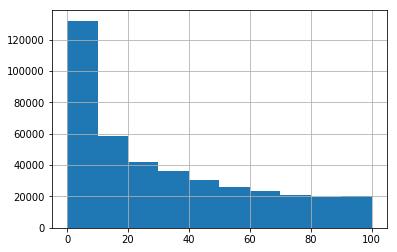

In [16]:
df['period'] = pd.to_datetime(df['donation_timestamp']) -  pd.to_datetime(df['date_posted'])
df['period'] = df['period'].apply(lambda x: x.days)
df[(df['period'] > -1) & (df['period'] < 101)]['period'].hist()
print('mean period: ', np.mean(df['period'].dropna()))

In [17]:
df.describe()

,donor_zip,donation_to_project,donation_optional_support,donation_total,donation_to_project_total,donation_optional_support_total,donation_total_total,is_teacher_acct_t,is_teacher_acct_f,donation_included_optional_support_t,...,resource_type_Visitors,grade_level_Grades 3-5,grade_level_Grades 6-8,grade_level_Grades 9-12,grade_level_Grades PreK-2,total,great_messages_proportion,teacher_referred_count,non_teacher_referred_count,period
count,328169.000000,525359.000000,525359.000000,525359.000000,525359.000000,525359.000000,525359.00000,525359.000000,525359.000000,525359.000000,...,525359.000000,525359.000000,525359.000000,525359.000000,525359.000000,5.252660e+05,439499.000000,524920.000000,524920.000000,525359.000000
mean,50150.848383,211.597007,35.122288,246.717129,389.137902,63.325409,452.46152,0.683318,5.216028,5.314061,...,0.001431,0.305696,0.172798,0.153579,0.367924,1.265063e+03,52.923527,0.777357,4.363301,54.913579
std,35006.265287,463.760220,69.867851,524.121420,709.579598,102.996593,802.58782,3.064463,6.899975,7.454563,...,0.037807,0.460702,0.378073,0.360545,0.482241,6.187255e+05,35.712941,2.227975,5.669542,55.972933
min,0.000000,-12.750000,-2.250000,-15.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-2230.000000
25%,11215.000000,39.800000,4.510000,46.455000,171.020000,26.620000,200.00000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.999900e+02,25.000000,0.000000,1.000000,9.000000
50%,48042.000000,127.350000,20.430000,149.270000,319.000000,51.120000,371.36000,0.000000,3.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.326400e+02,50.000000,0.000000,3.000000,37.000000
75%,90401.000000,264.340000,45.370000,309.000000,472.210000,81.400000,552.55000,1.000000,6.000000,6.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,4.715400e+02,83.000000,0.000000,5.000000,92.000000
max,99999.000000,147204.000000,21996.000000,169200.000000,213777.050000,31000.950000,244778.00000,390.000000,558.000000,607.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,4.484220e+08,100.000000,151.000000,304.000000,1474.000000


90 days of duration to get projects completed are at around 75%. So I choose 90 for the threshold as it covers majority of the population and the intervention plan will become more meaningful.

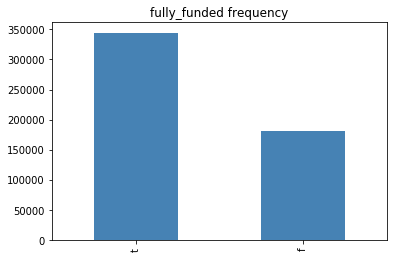

In [18]:
# if period > 90 & fully_funded == 't', then change its value to 'f'
df.loc[(df['period'] > 90) & (df['fully_funded'] == 't'), 'fully_funded'] = 'f'
del df['period']
del df['donation_timestamp']
df['fully_funded'].value_counts().plot.bar(title = "fully_funded frequency", color = "steelblue")

In [19]:
ratio = df["fully_funded"].value_counts(normalize = True)
ratio

t    0.655384
f    0.344616
Name: fully_funded, dtype: float64

In [20]:
df.groupby('resource_type')['total_price_including_optional_support'].describe()

,count,mean,std,min,25%,50%,75%,max
resource_type,,,,,,,,
Books,118788.0,481.020182,371.508326,20.73,283.2775,428.680,559.4825,22351.22
Other,55114.0,544.949226,5275.197108,0.00,283.8350,434.050,582.0575,1219512.20
Supplies,185494.0,487.723449,495.619151,10.98,267.8200,416.200,563.9200,67461.26
Technology,161120.0,758.536036,1145.815276,10.98,407.6400,572.385,885.3700,164382.84
Trips,4058.0,2276.399098,5239.390641,10.98,435.5550,859.195,1987.6275,100800.01
Visitors,752.0,1246.688471,1643.651934,115.00,453.2400,751.760,1356.7100,24767.07


In [21]:
df.groupby('resource_type' )['fully_funded'].describe()

,count,unique,top,freq
resource_type,,,,
Books,118788,2,t,82993
Other,55114,2,t,35055
Supplies,185494,2,t,124315
Technology,161120,2,t,98195
Trips,4058,2,t,3231
Visitors,752,2,t,504


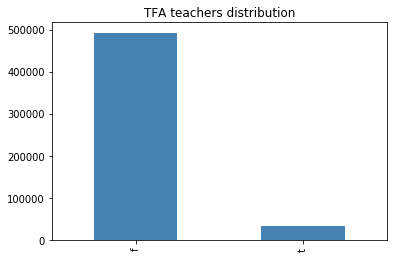

In [22]:
df['teacher_teach_for_america'].value_counts().plot.bar(title = "TFA teachers distribution", color = "steelblue")

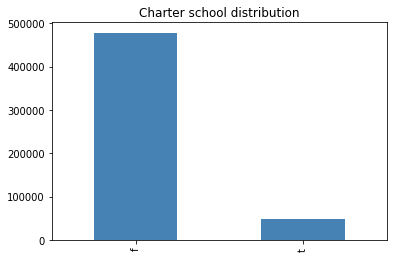

In [23]:
df['school_charter'].value_counts().plot.bar(title = "Charter school distribution", color = "steelblue")

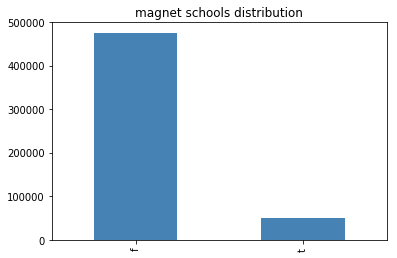

In [24]:
df['school_magnet'].value_counts().plot.bar(title = "magnet schools distribution", color = "steelblue")

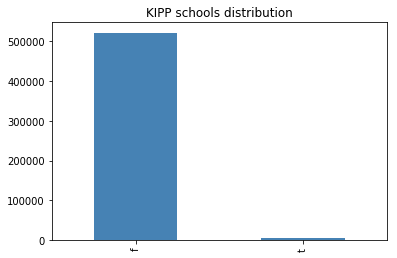

In [25]:
df['school_kipp'].value_counts().plot.bar(title = "KIPP schools distribution", color = "steelblue")

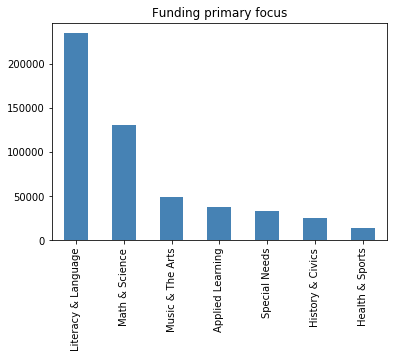

In [26]:
df['primary_focus_area'].value_counts().plot.bar(title = "Funding primary focus", color = "steelblue")

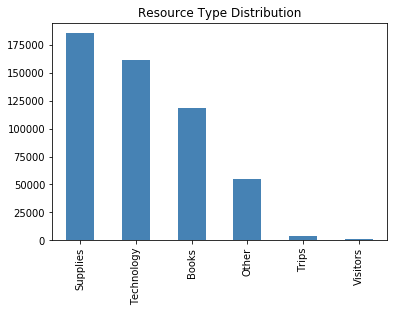

In [27]:
df['resource_type'].value_counts().plot.bar(title = "Resource Type Distribution", color = "steelblue")

In [28]:
ratio = df["resource_type"].value_counts(normalize = True)
ratio

Supplies      0.353103
Technology    0.306705
Books         0.226122
Other         0.104914
Trips         0.007725
Visitors      0.001431
Name: resource_type, dtype: float64

In [29]:
ratio = df["poverty_level"].value_counts(normalize = True)
ratio

highest poverty     0.585211
high poverty        0.255928
moderate poverty    0.134023
low poverty         0.024838
Name: poverty_level, dtype: float64

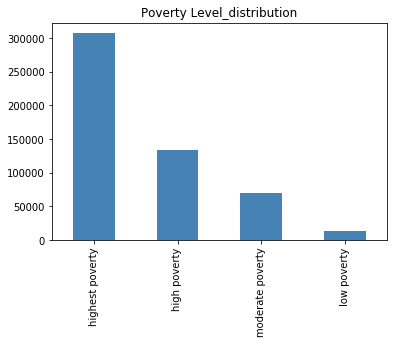

In [30]:
df['poverty_level'].value_counts().plot.bar(title = "Poverty Level_distribution", color = "steelblue")

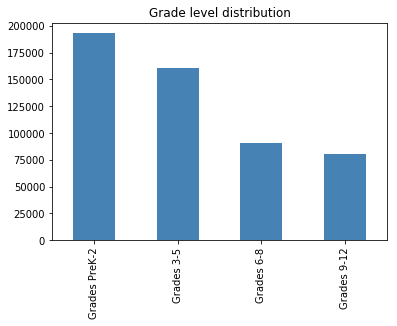

In [31]:
df['grade_level'].value_counts().plot.bar(title = "Grade level distribution", color = "steelblue")

In general, it is noticed that the data is imbalanced for true and false values. Besides, most of the projects are concentrated in Pre-K, highest-poverty regions and for the purpose of literacy. The most funded materials are supplies.

## 2.2.2 Changes and trends over time

In this section, we want to explore the landscape and trends of grantees(schools), donors and grantmaking.

### Sum and rate of fully funded projects over year

Not only we need to learn the landscape of grantees side, we should also capture the key features of grantmaking, and donors.

In [32]:
sum_cols = ['fully_funded']
df_by_day = df[sum_cols + ['date_posted']]
df_by_day = df_by_day.replace('t', 1).replace('f', 0)
df_by_day = df_by_day.set_index('date_posted')
df_by_day.index = pd.to_datetime(df_by_day.index)
df_by_day['year'] = df_by_day.index.year
df_by_year_sum = df_by_day.groupby('year').sum()
df_by_year_mean = df_by_day.groupby('year').mean()

<Figure size 432x288 with 0 Axes>

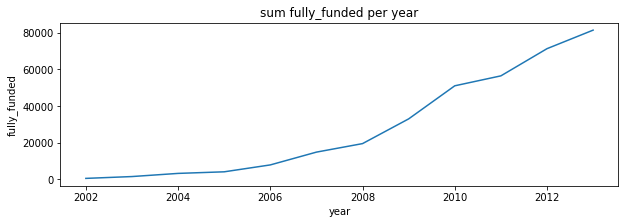

,fully_funded
year,
2002,386
2003,1389
2004,3116
2005,3986
2006,7761


In [33]:
def plot_hist(df, name='mean'):
    for col in df.columns:
        plt.clf()
        plt.figure(figsize=(10, 3))
        plt.plot(df.index, df[col],'')  
        plt.xlabel('year')
        plt.ylabel(col)
        plt.title('{} {} per year'.format(name, col))
        plt.show()

plot_hist(df_by_year_sum, 'sum')
df_by_year_sum.head()

<Figure size 432x288 with 0 Axes>

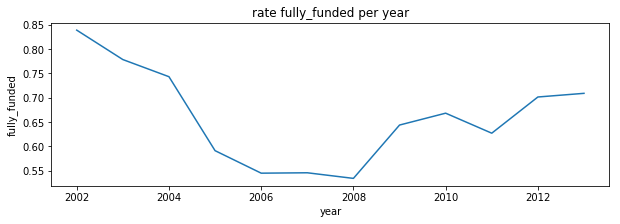

,fully_funded
year,
2002,0.839130
2003,0.778587
2004,0.743321
2005,0.591132
2006,0.544823


In [34]:
plot_hist(df_by_year_mean, 'rate')
df_by_year_mean.head()

In general, the sum of fully-funded projects increase year by year. From 2005 to 2008, there was a fluctuation for rate of fully-funded projects before it increased steadily after 2008. 

In conclusion, the years after 2007 is relatively a good duration to observe and examine funding patterns. 

### Changes and trends in grants and donors

In [35]:
mean_cols = ['donation_to_project_total', 'donation_total_total', 'total', 
             'total_price_including_optional_support']
df_by_day = df[mean_cols + ['date_posted']]
df_by_day = df_by_day.set_index('date_posted')
df_by_day.index = pd.to_datetime(df_by_day.index)
df_by_day['year'] = df_by_day.index.year
df_by_year = df_by_day.groupby('year').mean()
df_by_year.head()

,donation_to_project_total,donation_total_total,total,total_price_including_optional_support
year,,,,
2002,651.693717,689.418630,140.682132,763.835457
2003,583.295611,664.764215,416.857114,1242.825448
2004,404.167696,463.381405,108230.297061,505.464800
2005,453.493439,515.612830,383.344976,666.349474
2006,440.690607,508.241974,420.482488,693.818444


<Figure size 432x288 with 0 Axes>

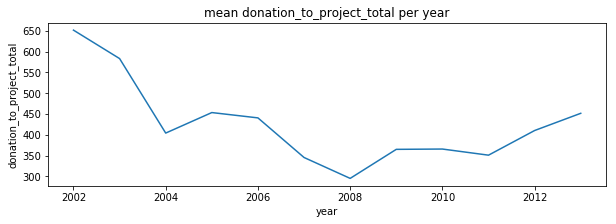

<Figure size 432x288 with 0 Axes>

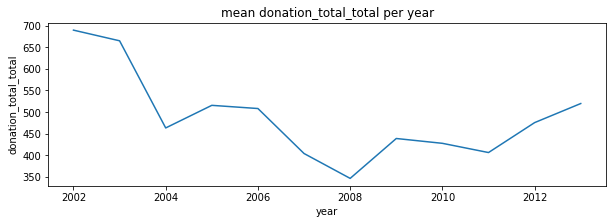

<Figure size 432x288 with 0 Axes>

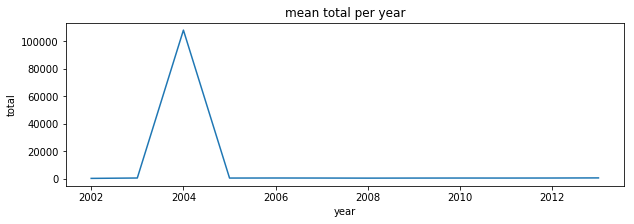

<Figure size 432x288 with 0 Axes>

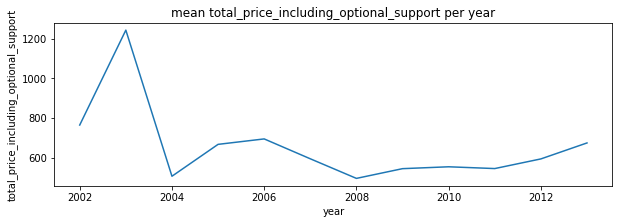

In [36]:
plot_hist(df_by_year)

In general, the amount of grants decrease since 2002. The general trends are the same as fully funded rates.Although there is a peak during the period of 2005-2006 for the items or total amount of grants, it stays at a relatively lower level compared to before. 

There is a peak value for total price of items donors sponsored for each project in 2004.

## 2.3 Cross-tabs

In order to further examine the relations between key factors and fully funded projects, the crosstabs would help us figure out.

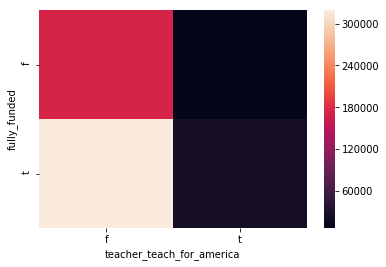

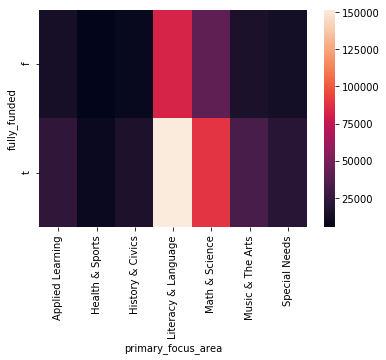

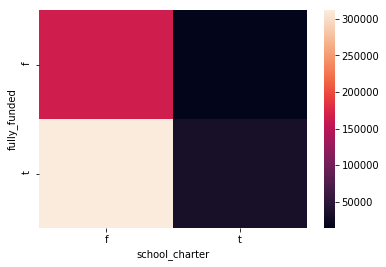

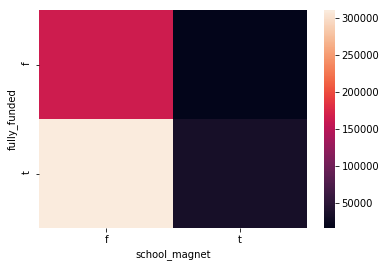

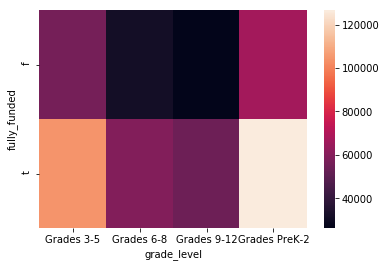

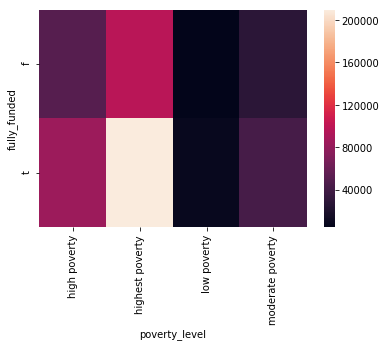

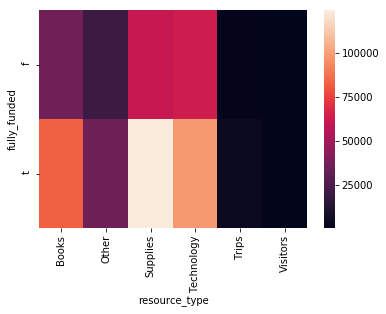

In [37]:
import seaborn as sns

def plot_crosstab(df):
    check_df = df.applymap(lambda x: isinstance(x, (int, float)))
    cols = ["teacher_teach_for_america", "primary_focus_area", "school_charter", "school_magnet", "grade_level", "poverty_level", "resource_type"]
    for col in cols:
        plt.clf()
        df_result = pd.crosstab(df['fully_funded'], df[col])
        sns.heatmap(df_result, xticklabels=df_result.columns, yticklabels=df_result.index)
        plt.show()
        
 
plot_crosstab(df)

The crosstab results fit what we found in the literature review. Compared to those projects that were not fully-funded, there were more Teach for America teachers in fully funded projects. Most of the highest poverty schools were fully funded. They often received books, and supplies from donors.

# Step 3: Pre Process Data

### *Remove  categorical data from the dataframe, but keep their dummy variables for those

We remove categorical data from the main dataframe as we do have produce the dummy variables in the data cleaning process before.

We also use 1/0 to represent t/f in the dataframe.

In [38]:
df = df.replace('f', 0).replace('t', 1)
exclude_cols = ['is_teacher_acct', 'donation_to_project', 'donation_optional_support','donation_total', 'dollar_amount','donation_included_optional_support', 'donor_zip',
               'payment_method', 'payment_included_acct_credit', 'payment_included_campaign_gift_card','payment_included_web_purchased_gift_card','payment_was_promo_matched','via_giving_page','for_honoree','school_state','teacher_prefix','primary_focus_area','resource_type','poverty_level','grade_level']
left_cols = [col for col in df.columns if (not col.endswith('id')) and col not in exclude_cols]
df = df[left_cols]
df.head()

,donation_to_project_total,donation_optional_support_total,donation_total_total,is_teacher_acct_t,is_teacher_acct_f,donation_included_optional_support_t,donation_included_optional_support_f,payment_included_acct_credit_t,payment_included_acct_credit_f,payment_included_campaign_gift_card_t,...,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
0,1273.82,224.79,1498.61,1.0,2.0,3.0,0.0,1.0,2.0,0.0,...,0.0,1,1.0,0,1.0,1.0,0.0,33.0,0.0,3.0
1,477.32,84.23,561.55,0.0,2.0,2.0,0.0,1.0,1.0,0.0,...,0.0,0,1.0,0,0.0,1.0,0.0,50.0,0.0,2.0
2,102.00,18.00,120.00,1.0,4.0,5.0,0.0,0.0,5.0,5.0,...,0.0,0,0.0,1,1.0,0.0,0.0,100.0,0.0,5.0
3,547.86,96.68,644.54,0.0,2.0,2.0,0.0,0.0,2.0,0.0,...,0.0,1,1.0,0,0.0,1.0,0.0,50.0,0.0,2.0
4,384.86,67.92,452.78,2.0,4.0,6.0,0.0,0.0,6.0,1.0,...,1.0,1,1.0,0,1.0,1.0,0.0,0.0,2.0,4.0


In [39]:
df = df[df['date_posted']> '2006-12-31']
df = df[df['date_posted']< '2013-12-31']

## Check and Fill out missing value

A standard and often very good approach is to replace missing values with mean, median and zeros. For numerical values we usually go with mean. If there are some outliers, try median first since it is less sensitive to them.

In [40]:
def check_missing(df):
    return [col for col in df.columns if any(df[col].isnull()) == True]

def fill_missing(df, col_name, method):
    if method == 'mean':
        df[col_name] = df[col_name].fillna(df[col_name].mean())
    elif method == 'median':
        df[col_name] = df[col_name].fillna(df[col_name].median())
    elif method == 'zero':
        df[col_name] = df[col_name].fillna(0)
        
missing_cols = check_missing(df)
missing_cols

['fulfillment_labor_materials',
 'students_reached',
 'total',
 'at_least_1_teacher_referred_donor',
 'at_least_1_green_donation',
 'three_or_more_non_teacher_referred_donors',
 'one_non_teacher_referred_donor_giving_100_plus',
 'donation_from_thoughtful_donor',
 'great_messages_proportion',
 'teacher_referred_count',
 'non_teacher_referred_count']

In [41]:
for col in missing_cols:
    fill_missing(df, col, 'mean')
check_missing(df)

[]

As we can see, there is no missing values.

## Drop out outliers

The impact of outliers could be not only seen in predictive modeling but also in statistical tests where it reduced the power of tests. Most paremetric statistics like means, standard deviations and correlations, and every statistics based on these, are highly sensitive to outliers. We care for the impact of outliers in predictivae modeling in this case.

From the statistics below, in order to get a better fit and more general solutions, we first detecting outliers, and then use '(data - mean) < 3 * std' to determine whether to drop these outliers.

In [42]:
df.describe()

,donation_to_project_total,donation_optional_support_total,donation_total_total,is_teacher_acct_t,is_teacher_acct_f,donation_included_optional_support_t,donation_included_optional_support_f,payment_included_acct_credit_t,payment_included_acct_credit_f,payment_included_campaign_gift_card_t,...,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
count,497765.000000,497765.000000,497765.000000,497765.000000,497765.000000,497765.000000,497765.000000,497765.000000,497765.000000,497765.000000,...,497765.000000,497765.000000,497765.000000,497765.000000,497765.000000,497765.000000,497765.000000,497765.000000,497765.000000,497765.000000
mean,385.714552,63.214511,448.926253,0.719175,5.386990,5.507109,0.599056,0.654156,5.452008,2.047717,...,0.250263,0.658058,0.722089,0.375794,0.535837,0.709914,0.013780,52.918555,0.819156,4.490154
std,640.117778,94.203037,724.415865,3.143353,7.016969,7.589426,2.257055,1.532062,7.829534,5.517584,...,0.433163,0.474361,0.447968,0.484328,0.498712,0.453800,0.116575,33.552155,2.279709,5.760707
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,170.820000,26.820000,200.000000,0.000000,2.000000,2.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000,0.000000,1.000000
50%,319.190000,51.630000,372.120000,0.000000,3.000000,3.000000,0.000000,0.000000,3.000000,1.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,52.918555,0.000000,3.000000
75%,471.300000,81.590000,551.710000,1.000000,7.000000,7.000000,1.000000,1.000000,7.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,78.000000,1.000000,5.000000
max,139725.410000,18750.000000,158475.410000,390.000000,558.000000,607.000000,288.000000,140.000000,607.000000,606.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000,151.000000,304.000000


In [43]:
def find_outliers(df, col):
    return df[((df[col] - df[col].mean()) / df[col].std()).abs() >= 3]

def find_all_outliers(df):
    counter = []
    for f in df.columns:
        if f != 'date_posted':
            counter.append((f, len(find_outliers(df, f))))
    counter.sort(key=lambda x: x[1], reverse=True)
    counter = counter[:2]
    return counter
        
cols = find_all_outliers(df)
cols

[('school_magnet', 46515), ('primary_focus_area_Music & The Arts', 46181)]

In [44]:
# use (data - mean) < 3 * std to determine whether to drop
def drop_outliers(df, col):
    return df[((df[col] - df[col].mean()) / df[col].std()).abs() < 3]
old_len = len(df)
for f, _ in cols:
    df = drop_outliers(df, f)

print('drop out {} outliers'.format(old_len - len(df)))

drop out 87610 outliers


# Step 4: Generate Features

There are 153 variables in our data. Unneeded, irrelevant and redundant attributes from data that do not contribute to the accuracy of a predictive model or may in fact decrease the accuracy of the model. In order to find variables that most contribute to the prediction variable, we first plot and rank features importance through Decision Tree. This step will help us reduce overfitting problem, improve accuracy and reduce training time.

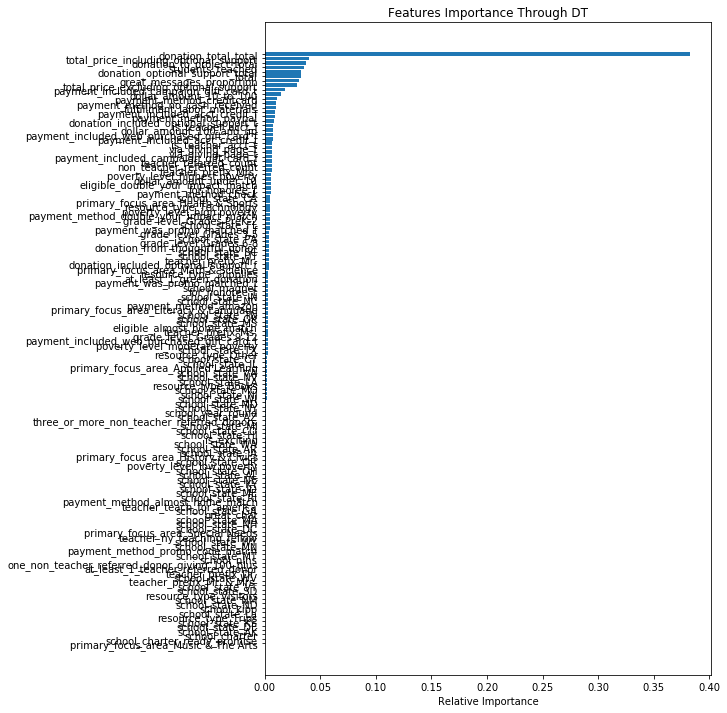

In [45]:
def sort_features_through_dt(df_features, df_label):
    features = df_features.columns
    model = DecisionTreeClassifier()
    model.fit(df_features, df_label)
    importances = model.feature_importances_
    sorted_idx = np.argsort(importances)
    padding = np.arange(len(features)) + 0.5
    plt.figure(figsize=(8, 12))
    plt.barh(padding, importances[sorted_idx], align='center')
    plt.yticks(padding, np.asarray(features)[sorted_idx])
    plt.xlabel("Relative Importance")
    plt.title("Features Importance Through DT")
    
    return list(np.asarray(features)[sorted_idx][::-1])

df['fully_funded'] = df['fully_funded'].astype('int')
df['fully_funded'] = 1 - df['fully_funded']
all_x= df.drop(['date_posted', 'fully_funded'], axis=1)
all_y = df['fully_funded']

sorted_train_features = sort_features_through_dt(all_x, all_y)

As a result there are the top 43 features in the analysis given the feature importance ranking. 

In [46]:
count = int(len(sorted_train_features) * 0.33)
all_x = all_x[sorted_train_features[:count]]
all_x.head()

,donation_total_total,total_price_including_optional_support,donation_to_project_total,students_reached,donation_optional_support_total,total,great_messages_proportion,total_price_excluding_optional_support,payment_included_campaign_gift_card_t,dollar_amount_10_to_100,...,primary_focus_area_Health & Sports,resource_type_Technology,poverty_level_high poverty,payment_method_double_your_impact_match,grade_level_Grades PreK-2,school_state_FL,payment_was_promo_matched_f,grade_level_Grades 3-5,school_state_PA,grade_level_Grades 6-8
507037,820.96,820.96,673.19,40.0,147.77,647.99,50.0,673.19,0.0,1.0,...,0,1,1,0.0,0,0,2.0,1,0,0
438964,556.76,556.75,473.24,24.0,83.52,397.53,0.0,473.24,0.0,0.0,...,0,0,0,1.0,0,0,2.0,1,0,0
31582,271.38,271.39,230.68,27.0,40.70,178.95,50.0,230.68,0.0,0.0,...,0,0,0,1.0,1,0,2.0,0,0,0
148949,60.00,487.59,51.00,750.0,9.00,337.91,100.0,414.45,0.0,2.0,...,0,0,1,0.0,1,0,2.0,0,0,0
514338,413.86,413.86,351.78,25.0,62.08,279.96,63.0,351.78,2.0,10.0,...,0,1,0,0.0,0,0,9.0,0,0,1


# Step 5: Split Train and Test Set
## construct test window

We select 2007 to 2014 as main dataframe. In general, we create the training sets for 3 years long and the test sets for the year afterwards. For example, we train 2009-2011, and test 2012. Overall, we will produce 5 train-test windows. The result for each window is also plotted behind.

In [47]:
def norm(df_features):
    # normalize
    df_features = preprocessing.MinMaxScaler().fit_transform(df_features)
    df_features = preprocessing.normalize(df_features, norm='max')
    return df_features

def build_test_window(df):
    dataset = []
    name = 'date_posted'
    label_name = 'fully_funded'
    start, end = 2007, 2011
    for year in range(start, end):
        test_year = start + 3
        df_left = df[(df[name] >= '{}-01-01'.format(start)) & (df[name] <= '{}-12-31'.format(start+2))]
        y_train = df_left[label_name]
        x_train = df_left[all_x.columns]
        
        df_right = df[(df[name] >= '{}-01-01'.format(test_year)) & (df[name] <= '{}-12-31'.format(test_year))]
        y_test = df_right[label_name]
        x_test = df_right[all_x.columns]
        
        # normalization
        x_train = norm(x_train)
        x_test = norm(x_test)
        dataset.append((x_train, y_train, x_test, y_test))
    return dataset


dataset = build_test_window(df)
print("has construct {} test window, every three years'data as one".format(len(dataset)))

has construct 4 test window, every three years'data as one


In [48]:
data_description = ['train: 2007/01/01-2009/12/31, test: 2010/01/01-2010/12/31', 'train: 2008/01/01-2010/12/31, test: 2011/01/01-2011/12/31',
                   'train: 2009/01/01-2011/12/31, test: 2012/01/01-2012/12/31', 'train: 2010/01/01-2012/12/31, test: 2013/01/01-2013/12/31']

for idx, (x_train, y_train, x_test, y_test) in enumerate(dataset):
    print('='*80)
    print(data_description[idx])
    print('- '*40)
    print("x_train >>")
    print(x_train)
    print('- '*40)
    print("y_train >>")
    print(y_train.values)
    print('- '*40)
    print("x_test >>")
    print(x_test)
    print('- '*40)
    print("y_test >>")
    print(y_test.values)
    print('- '*40)
    print("\n\n")

train: 2007/01/01-2009/12/31, test: 2010/01/01-2010/12/31
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
x_train >>
[[0.02573771 0.02236669 0.0246301  ... 1.         0.         0.        ]
 [0.00624641 0.0234981  0.0058316  ... 0.         0.         0.        ]
 [0.01315198 0.01075778 0.01304785 ... 1.         0.         0.        ]
 ...
 [0.02600295 0.02353483 0.02579533 ... 0.         0.         0.        ]
 [0.01731919 0.01429203 0.01657392 ... 0.         0.         0.        ]
 [0.00608538 0.00351708 0.00582391 ... 0.         0.         0.        ]]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
y_train >>
[1 1 0 ... 0 0 0]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
x_test >>
[[0.04036398 0.00434201 0.0373458  ... 0.         0.         0.        ]
 [0.27318556 0.04576622 0.24508161 ... 0.         0.         1.        ]
 [0.04653298 0.00555868 0.04216447 ... 1.         0.       

# Step 6: Build Classifier

Derived from the project descriptions, we use Logistic Regression, K-NN, Decision Trees, SVM, Random Forest, Boosting and Bagging as classifers. For each classifier, we select several default parameters into grid search

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier,
                              BaggingClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (precision_recall_curve, roc_auc_score, roc_curve, auc,
                             precision_score, recall_score, f1_score)

In [50]:
classifier_constructors = {
    'Dummy': DummyClassifier,
    'LR': LogisticRegression,
    'KNN': KNeighborsClassifier,
    'DT': DecisionTreeClassifier,
    'SVM': SVC,
    'RF': RandomForestClassifier,
    'GB': GradientBoostingClassifier,
    'BG': BaggingClassifier
}

grid = dict()
grid['Dummy'] = {
}
grid['LR'] = {
    'penalty': ['l1', 'l2'],
    'C': [0.0001 * (10**i) for i in range(5)]
}
grid['DT'] = {
    'max_depth': [10, 50, 100],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 200]
}
grid['KNN'] = {
    'n_neighbors': [5, 50, 100],
    'algorithm': ['ball_tree', 'kd_tree'],
    'weights': ['uniform', 'distance']
}
grid['SVM'] = {
    'C': [0.00001,0.0001,0.001,0.01,0.1,1,10],
    'gamma': [1e-3, 1e-4],
    'kernel': ['rbf', 'linear']
}
grid['RF'] = {
    'n_estimators': [10, 100, 1000],
    'max_depth': [10, 50, 100], 
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10]
}
grid['GB'] = {
    'n_estimators': [10, 100, 1000],
    'learning_rate' : [0.1, 0.5]
}
grid['BG'] = {
    'n_estimators': [10, 100, 1000],
    "bootstrap": [True, False],
    "bootstrap_features": [True, False]
}

## Temporal validation
Since our data contains time series components, we could not use KFold cross validations. We would like to use f1-score to find the best parameters.

In [51]:
import warnings
warnings.filterwarnings('ignore')

def classify(x_train, y_train, x_test, y_test, clf):
    clf.fit(x_train, y_train)
    y_pre = clf.predict(x_test)
    return f1_score(y_test, y_pre)

In [52]:
def select_best_parameters(x_train, y_train, x_test, y_test):
    # iter three times
    number = 3
    # store all the scores and parameters
    classifiers = {}
    results = {}
    for k, clf_constructor in classifier_constructors.items():
        results[k] = []
        params = grid[k]
        for p in ParameterGrid(params):
            clf = clf_constructor(**p)
            f1_scores = [classify(x_train, y_train, x_test, y_test, clf) for i in range(number)]
            f1_score_mean = sum(f1_scores) / len(f1_scores)
            results[k].append((p, f1_score_mean))
    return results

In [53]:
all_best = {}
for x_train, y_train, x_test, y_test in dataset:
    results = select_best_parameters(x_train, y_train, x_test, y_test)
    for k, p_list in results.items():
        p = max(p_list, key=lambda x: x[1])
        if k not in all_best:
            all_best[k] = [p]
        else:
            all_best[k].append(p)

In [54]:
# print last 4 window value
for k, p in all_best.items():
    print(k)
    print('train: 2007-2009, test: 2010', p[-4])
    print('train: 2008-2010, test: 2011', p[-3])
    print('train: 2009-2011, test: 2012', p[-2])
    print('train: 2010-2012, test: 2013', p[-1])

Dummy
train: 2007-2009, test: 2010 ({}, 0.3689167365794244)
train: 2008-2010, test: 2011 ({}, 0.38384222621454506)
train: 2009-2011, test: 2012 ({}, 0.380926418458614)
train: 2010-2012, test: 2013 ({}, 0.3690837750221201)
LR
train: 2007-2009, test: 2010 ({'C': 0.1, 'penalty': 'l1'}, 0.4904306220095694)
train: 2008-2010, test: 2011 ({'C': 0.1, 'penalty': 'l1'}, 0.4904306220095694)
train: 2009-2011, test: 2012 ({'C': 0.1, 'penalty': 'l1'}, 0.4904306220095694)
train: 2010-2012, test: 2013 ({'C': 0.1, 'penalty': 'l1'}, 0.4904306220095694)
KNN
train: 2007-2009, test: 2010 ({'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'distance'}, 0.44906444906444903)
train: 2008-2010, test: 2011 ({'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'distance'}, 0.44906444906444903)
train: 2009-2011, test: 2012 ({'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'distance'}, 0.44906444906444903)
train: 2010-2012, test: 2013 ({'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'distance

As we see, when year changes, the best parameters don't change in SVM, KNN, LR classifiers.

For all classifiers, regarding the F1 score, the 2011-2012/2013 training and test splits perform well for all classifiers except for the Bagging.

# Step 7: Evaluate Classifier

In this section, in order to evaluate the classifers, we plot accuracy, precision at different levels, recall at different levels, F1, area under curve and precision-recall curves. Then we select best perform classifers based on different thresholds, and compare the results with baselines.

In [55]:
# evalute metrics
def evaluate_classifier(y_test, y_pre, y_prob, cost_time=0):
    ret = {
        'precision': float("%.4f" % precision_score(y_test, y_pre)),
        'recall': float("%.4f" % recall_score(y_test, y_pre)),
        'f1': float("%.4f" % f1_score(y_test, y_pre)),
        'auc': float("%.4f" % roc_auc_score(y_test, y_prob)),
        'cost_time': float("%.4f" % cost_time)
    }

    return ret

def evaluate_classifiers(clfs, X_test, y_test, threshold, is_percent=False, percent=0):
    metrics = dict()
    probas = dict()
    for k, clf in clfs.items():
        start = time.time()
        if hasattr(clf, 'predict_proba'):
            y_prob = clf.predict_proba(X_test)[:, 1]
        else:
            y_prob = clf.decision_function(X_test)
        
        if is_percent:
            #print(k)
            #print("y_prob", y_prob)
            y_prob_sorted = sorted(y_prob, reverse=True)
            #print("y_prob_sorted", y_prob_sorted)
            pos = int(len(y_prob_sorted) * percent)
            #print("POS:%d, len: %d, percent: %f" % (pos, len(y_prob_sorted), percent))
            threshold = y_prob_sorted[pos]
            #print("threshold", threshold)
            
        y_pre = np.asarray([1 if run >= threshold else 0 for run in y_prob])
        cost_time = time.time() - start
        metric = evaluate_classifier(y_test, y_pre, y_prob, cost_time)
        probas[k] = y_prob
        
        number_scored = len(y_prob)
        num_above_thresh = len(y_prob[y_prob >= threshold])
        pct_above_thresh = num_above_thresh / float(number_scored)
        metric['percent'] = float("%.4f" % pct_above_thresh)
        metrics[k] = metric
    return metrics, probas

In [56]:
#2011-2012/2013
classifiers = {}
x_train, y_train, x_test, y_test = dataset[-1]

for k, p in all_best.items():
    clf = classifier_constructors[k](**p[-1][0])
    clf.fit(x_train, y_train)
    classifiers[k] = clf
    
metrics, probas = evaluate_classifiers(classifiers, x_test, y_test, 0.1)
metrics

{'BG': {'auc': 0.7054,
  'cost_time': 0.3097,
  'f1': 0.5183,
  'percent': 1.0,
  'precision': 0.3498,
  'recall': 1.0},
 'DT': {'auc': 0.6273,
  'cost_time': 0.0008,
  'f1': 0.4792,
  'percent': 0.708,
  'precision': 0.358,
  'recall': 0.7247},
 'Dummy': {'auc': 0.4978,
  'cost_time': 0.0022,
  'f1': 0.3851,
  'percent': 0.4345,
  'precision': 0.3475,
  'recall': 0.4317},
 'GB': {'auc': 0.7651,
  'cost_time': 0.0198,
  'f1': 0.6034,
  'percent': 0.1864,
  'precision': 0.8678,
  'recall': 0.4626},
 'KNN': {'auc': 0.5938,
  'cost_time': 0.2444,
  'f1': 0.5202,
  'percent': 0.8914,
  'precision': 0.3621,
  'recall': 0.9229},
 'LR': {'auc': 0.6768,
  'cost_time': 0.0013,
  'f1': 0.5183,
  'percent': 1.0,
  'precision': 0.3498,
  'recall': 1.0},
 'RF': {'auc': 0.6926,
  'cost_time': 0.0031,
  'f1': 0.5196,
  'percent': 0.9877,
  'precision': 0.3518,
  'recall': 0.9934},
 'SVM': {'auc': 0.6934,
  'cost_time': 0.0796,
  'f1': 0.2931,
  'percent': 0.1287,
  'precision': 0.5449,
  'recall': 0.

## Draw AUC, 2010-2012/2013

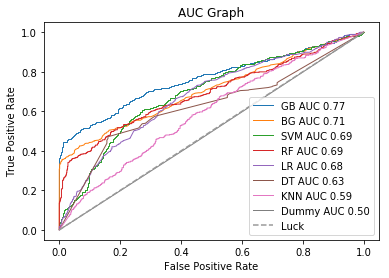

In [57]:
def draw_auc(probas, y_test):
    plt.clf()
    auc_list = []
    for k, prob in probas.items():
        fpr, tpr, thresholds = roc_curve(y_test, prob)
        roc_auc = auc(fpr, tpr)
        auc_list.append((k, roc_auc))
        
    auc_list.sort(key=lambda x: x[1], reverse=True)
    
    for k, roc_auc in auc_list:
        fpr, tpr, thresholds = roc_curve(y_test, probas[k])
        plt.plot(fpr, tpr, lw=1, label=('%s AUC %.2f' % (k, roc_auc)))
    
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC Graph')
    plt.legend(loc="lower right")

draw_auc(probas, y_test)

## Draw Precision-Recall Curves, 2010-2012/2013

threshold	percent		precision	recall


<Figure size 432x288 with 0 Axes>

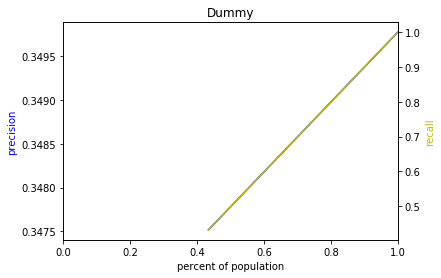

threshold	percent		precision	recall


<Figure size 432x288 with 0 Axes>

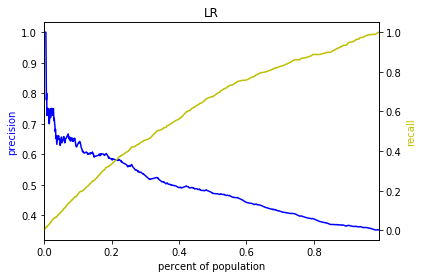

threshold	percent		precision	recall


<Figure size 432x288 with 0 Axes>

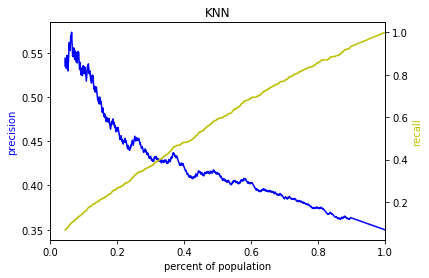

threshold	percent		precision	recall


<Figure size 432x288 with 0 Axes>

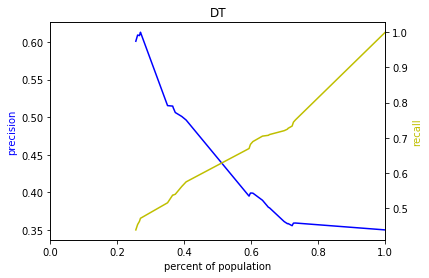

threshold	percent		precision	recall


<Figure size 432x288 with 0 Axes>

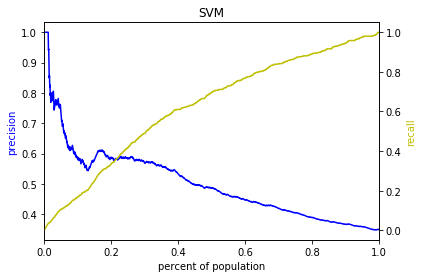

threshold	percent		precision	recall


<Figure size 432x288 with 0 Axes>

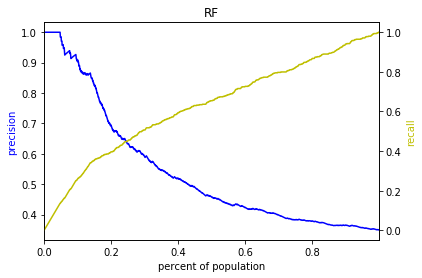

threshold	percent		precision	recall


<Figure size 432x288 with 0 Axes>

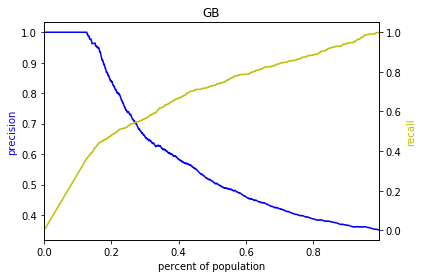

threshold	percent		precision	recall


<Figure size 432x288 with 0 Axes>

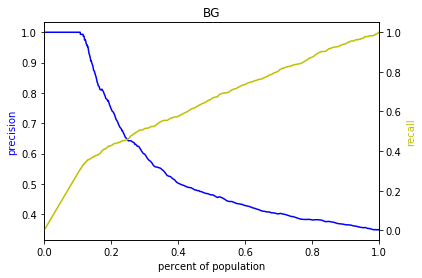

In [58]:
def plot_precision_recall(y_test, key):
    plt.clf()
    y_prob = probas[key]
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_prob)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_per_thresh = []
    number_scored = len(y_prob)
    print("threshold\tpercent\t\tprecision\trecall")
    for i, value in enumerate(pr_thresholds):
        num_above_thresh = len(y_prob[y_prob >= value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_per_thresh.append(pct_above_thresh)
    
    pct_per_thresh = np.array(pct_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax1.set_xlim(0, max(pct_per_thresh))
    ax2 = ax1.twinx()
    ax2.plot(pct_per_thresh, recall_curve, 'y')
    ax2.set_ylabel('recall', color='y')
    ax2.set_xlim(0, max(pct_per_thresh))
    plt.title(key)
    plt.show()
    
for key in probas.keys():
    plot_precision_recall(y_test, key)

## the precision, recall, AUC and F1 table, 2010-2012/2013, threshold 0.1

In [59]:
data = dict()
data['key'] =  ['precision', 'recall', 'f1', 'auc', 'cost_time']

for k, metric in metrics.items():
    data[k] = [metric[item] for item in data['key']]

df_result = pd.DataFrame(data)

df_result = df_result.set_index('key')
df_result.head()

,BG,DT,Dummy,GB,KNN,LR,RF,SVM
key,,,,,,,,
precision,0.3498,0.3580,0.3475,0.8678,0.3621,0.3498,0.3518,0.5449
recall,1.0000,0.7247,0.4317,0.4626,0.9229,1.0000,0.9934,0.2004
f1,0.5183,0.4792,0.3851,0.6034,0.5202,0.5183,0.5196,0.2931
auc,0.7054,0.6273,0.4978,0.7651,0.5938,0.6768,0.6926,0.6934
cost_time,0.3097,0.0008,0.0022,0.0198,0.2444,0.0013,0.0031,0.0796


As we can see, this table shows the summary of precision, recall, f1, auc, cost time of these 7 classifers.

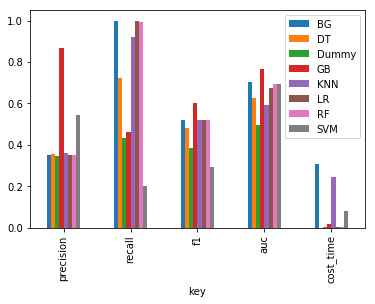

In [60]:
df_result.plot.bar();
plt.show()

This is the graph for the table above. However, as we compared the cost time for classifiers, the Bagging classifier consume much more time than the other 6 classifers.

## Appendix: the evaluation summary for the classifiers at different thresholds, 2010-2012/2013

In [61]:
def train_classifiers(best_params, idx):
    #2011-2012/2013
    classifiers = {}
    x_train, y_train, x_test, y_test = dataset[idx]

    for k, p in best_params.items():
        clf = classifier_constructors[k](**p[idx][0])
        clf.fit(x_train, y_train)
        classifiers[k] = clf

    return classifiers

classifiers = train_classifiers(all_best, -1)
thresholds = [0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5]
threshold_metrics = {}
for threshold in thresholds:
    threshold_metrics[str(threshold)] = evaluate_classifiers(classifiers, x_test, y_test, threshold)

In [62]:
for idx, threshold in enumerate(thresholds):
    print('-'*80)
    print("Threshold: ", threshold)
    print('-'*80)

    metrics, probas = threshold_metrics[str(threshold)]
    data = dict()
    data['key'] =  ['precision', 'recall', 'f1', 'auc', 'cost_time', 'percent']

    for k, metric in metrics.items():
        data[k] = [metric[item] for item in data['key']]

    df_result = pd.DataFrame(data)

    df_result = df_result.set_index('key')
    print(df_result)
    print()

--------------------------------------------------------------------------------
Threshold:  0.001
--------------------------------------------------------------------------------
               BG      DT   Dummy      GB     KNN      LR      RF     SVM
key                                                                      
precision  0.3498  0.3609  0.3411  0.5131  0.3637  0.3498  0.3498  0.5471
recall     1.0000  0.6828  0.4537  0.7335  0.9317  1.0000  1.0000  0.2048
f1         0.5183  0.4722  0.3894  0.6038  0.5232  0.5183  0.5183  0.2981
auc        0.7082  0.6038  0.4911  0.7649  0.5938  0.6768  0.6933  0.6934
cost_time  0.3130  0.0007  0.0022  0.0208  0.1995  0.0012  0.0030  0.0879
percent    1.0000  0.6618  0.4653  0.5000  0.8960  1.0000  1.0000  0.1310

--------------------------------------------------------------------------------
Threshold:  0.01
--------------------------------------------------------------------------------
               BG      DT   Dummy      GB     KN

# Appendix: the evaluation summary for the classifiers at different percents of population over time

In [63]:
data_description = ['train: 2007-2009, test: 2010', 'train: 2008-2010, test: 2011',
                   'train: 2009-2011, test: 2012', 'train: 2010-2012, test: 2013']

percents = [0.1, 0.17, 0.19, 0.22, 0.26, 0.3]

for idx, (x_train, y_train, x_test, y_test) in enumerate(dataset):
    print('-'*80)
    print(data_description[idx])

    classifiers = train_classifiers(all_best, idx)
    
    threshold_metrics = {}
    for percent in percents:
        threshold_metrics[str(percent)] = evaluate_classifiers(classifiers, x_test, y_test, percent, True, percent)[0]
        
    data = dict()
    data['key'] =  ['top-%s' % item for item in percents]

    for k, p in all_best.items():
        data[k] = [threshold_metrics[str(percent)][k]['precision'] for percent in percents]

    df_result = pd.DataFrame(data)
    df_result = df_result.set_index('key')
    print(df_result)
    print()

--------------------------------------------------------------------------------
train: 2007-2009, test: 2010
              BG      DT   Dummy      GB     KNN      LR      RF     SVM
key                                                                     
top-0.1   1.0000  0.5565  0.3280  1.0000  0.5308  0.6391  0.8846  0.5846
top-0.17  0.7637  0.5565  0.3651  0.9140  0.4751  0.6018  0.6697  0.6109
top-0.19  0.7364  0.5565  0.3497  0.8583  0.4696  0.5887  0.6194  0.5911
top-0.22  0.6750  0.5565  0.3527  0.7937  0.4510  0.5819  0.5909  0.5804
top-0.26  0.6397  0.5565  0.3406  0.7189  0.4527  0.5634  0.5382  0.5888
top-0.3   0.5909  0.5639  0.3310  0.6615  0.4308  0.5185  0.5256  0.5692

--------------------------------------------------------------------------------
train: 2008-2010, test: 2011
              BG      DT   Dummy      GB     KNN      LR      RF     SVM
key                                                                     
top-0.1   1.0000  0.5892  0.3734  1.0000  0.5308 